In [ ]:
import importlib
import risk_instruments
import pandas as pd
import numpy as np
import os
import sys
import pandas as pd
import plotly.io as pio
import seaborn as sns
import plotly.graph_objects as go


from risk_instruments.database import DBconnect
from risk_instruments.universal_analysis import woe_stab, woe_line
from risk_instruments.express_analysis import gain_chart
from configures import user, password
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.pipeline import Pipeline
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats.distributions import chi2
from matplotlib import pyplot as plt
from lightgbm import LGBMClassifier, plot_importance
from scipy.stats import bernoulli, norm
from plotly.subplots import make_subplots


importlib.reload(risk_instruments.database)
pio.renderers.default='notebook'
pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)
display(HTML("<style>.container { width:100% !important; }</style>"))

## Читаем данные

In [ ]:
df = pd.read_csv('../Desktop/scoring_model_data.csv')

In [ ]:
df.head()

,user_id,d4p12,month_dt,max_util,avg_util,credits_2y,credits_4y,bad_history_credits_flg,other_util,avg_term,min_term,avg_limit_mortgage,min_limit_mfo,close_balance_amt,soc_dem_score,max_delq_cnt,avg_active_time,last_credit_time_years
0,0,0,2019-01-01,0.991360,0.991360,0.0,1.0,1,1.000000,29.000000,29.0,-1.0,-1.0,51864.00,-5.898175,0.0,NaN,0.0
1,1,0,2019-01-01,0.928482,0.271159,0.0,0.0,1,0.296724,86.928571,1.0,-1.0,-1.0,1424742.89,-7.067999,0.0,49.0,1.0
2,2,0,2019-01-01,1.418333,0.079951,0.0,0.0,1,0.219805,-0.065789,-24.0,-1.0,20000.0,254827.00,-7.295431,0.0,47.0,16.0
3,3,0,2019-01-01,1.042425,0.230797,1.0,1.0,1,0.284345,116.615385,-5.0,-1.0,-1.0,138969.00,-5.073265,0.0,23.0,3.0
4,4,1,2019-01-01,0.960127,0.326562,2.0,2.0,1,0.334188,188.200000,1.0,-1.0,-1.0,53620.00,-7.226236,0.0,14.0,2.0


## Описание признаков

1. max_util (максимальная утилизация по КК)
2. avg_util (средняя утилизация по КК)
3. credits_2y (количество кредитов за последние 2 года)
4. credits_4y (количество кредитов за последние 4 года)
5. bad_history_credits_flg (наличие кредитов в подозрительных кредитных организациях)
6. other_util (отношение задолженности к сумме кредитов в других организациях)
7. avg_term (средний срок кредита)
8. min_term (минимальный срок кредита)
9. avg_limit_mortgage (средний лимит по ипотекам)
10. min_limit_mfo (минимальный лимит в мфо)
11. close_balance_amt (выплаченная сумма)
12. soc_dem_score (скоринговый балл основанный на соц-дем показателях)
13. max_delq_cnt (максимальное число просрочек по кредиту)
14. avg_active_time (среднее оставшееся время по открытам кредитам)
15. last_credit_time_years (время (в годах) с последнего закрытого кредита)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222275 entries, 0 to 222274
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   user_id                  222275 non-null  int64  
 1   d4p12                    222275 non-null  int64  
 2   month_dt                 222275 non-null  object 
 3   max_util                 222275 non-null  float64
 4   avg_util                 222275 non-null  float64
 5   credits_2y               222275 non-null  float64
 6   credits_4y               222275 non-null  float64
 7   bad_history_credits_flg  222275 non-null  int64  
 8   other_util               222275 non-null  float64
 9   avg_term                 222237 non-null  float64
 10  min_term                 222237 non-null  float64
 11  avg_limit_mortgage       222275 non-null  float64
 12  min_limit_mfo            222275 non-null  float64
 13  close_balance_amt        222275 non-null  float64
 14  soc_

## Разбиение выборки

In [ ]:
def test_val_split(df, val_size=0.2, test_size=0.2):

    """
        Функция для разбиения выборки на три части по времени (hold-out подход)

        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        val_size : str
            размер валидационной выборки
        test_size : str
            размер тестовой выборки

        Returns
        ---
        df : pandas.DataFrame
           исходный датафрейм с новой колонкой sample_part принимающей три значения:
           'train', 'val', 'test'

    """

    X_train, X_test, y_train, y_test = train_test_split(
        df[features], df['d4p12'], test_size=val_size+test_size, shuffle=False)
    df.assign(sample_part='')
    df.loc[X_test.index, 'sample_part'] = 'test'
    X_val, X_test, y_val, y_test = train_test_split(
        df[features][df['sample_part'] == 'test'], df['d4p12'][df['sample_part'] == 'test'],\
        test_size=test_size / (test_size + val_size), shuffle=False)
    df.loc[X_val.index, 'sample_part'] = 'validation'
    df.loc[X_train.index, 'sample_part'] = 'train'
    return df

## Визуализация разбиения

In [ ]:
df.columns

Index(['user_id', 'd4p12', 'month_dt', 'max_util', 'avg_util', 'credits_2y',
       'credits_4y', 'bad_history_credits_flg', 'other_util', 'avg_term',
       'min_term', 'avg_limit_mortgage', 'min_limit_mfo', 'close_balance_amt',
       'soc_dem_score', 'max_delq_cnt', 'avg_active_time',
       'last_credit_time_years'],
      dtype='object')

In [ ]:
features = [\
    'max_util',
    'avg_util',
    'credits_2y',
    'credits_4y',
    'bad_history_credits_flg',
    'other_util', 'avg_term',
    'min_term',
    'avg_limit_mortgage',
    'min_limit_mfo',
    'close_balance_amt',
    'soc_dem_score',
    'max_delq_cnt',
    'avg_active_time',
    'last_credit_time_years'
]

In [ ]:
df = df.sort_values(by=['user_id'])
df = test_val_split(df)

In [ ]:
def sample_part_distribution(df, date='month_dt', train_nm='train', val_nm='validation', test_nm='test', title='Выборка для построения'):

    """
        Функция для визуализации разбиения категорий в колонке sample_part

        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        date : str
            поле по которому будет проводится группировка по времени
        test_nm : str
            название тестовой категории в sample_part
        val_nm : str
            название валидацинной категории в sample_part
        train_nm : str
            название категории для обучения в sample_part
        title : str
            название категории для обучения в sample_part

    """

    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Bar(
            x=sorted(set(df[date][df['sample_part'] == train_nm])),
            y=df[df['sample_part'] == train_nm].groupby(date).user_id.count(),
            marker_color='indianred', name='train'
        ))
    fig.add_trace(
        go.Bar(
            x=sorted(set(df[date][df['sample_part'] == val_nm])),
            y=df[df['sample_part']== val_nm].groupby(date).user_id.count(),
             marker_color='lightsalmon', name='validation'
        ))
    fig.add_trace(
        go.Bar(
            x=sorted(set(df[date][df['sample_part']== test_nm])),
            y=df[df['sample_part']== 'test'].groupby(date).user_id.count(),
            marker_color='lightslategray', name='test'
        ))
    fig.update_layout(barmode='relative', title_text=title)
    fig.show()

In [ ]:
sample_part_distribution(df)

## Как построить матрицу корреляций: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

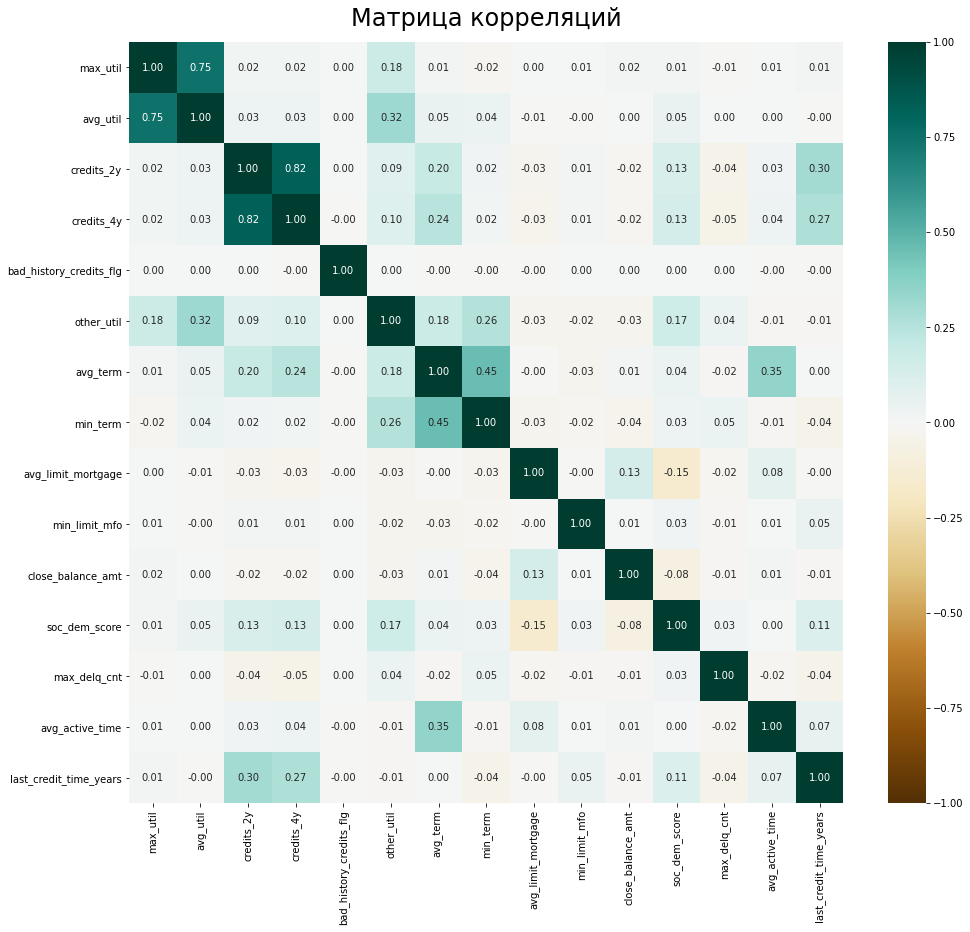

In [ ]:
plt.figure(figsize=(16, 14))


heatmap = sns.heatmap(df[features].corr(), mask=None, vmin=-1, vmax=1, annot=True, cmap='BrBG', fmt=".2f")
heatmap.set_title('Матрица корреляций', fontdict={'fontsize':24}, pad=16);

## Заполнение пропусков

In [ ]:
df = df.fillna(df.median())

## Отбор признаков с помощью фильтрации

In [ ]:
def filter_by_score(df, features=None, target='d4p12', score=roc_auc_score, greater_is_better=True, top_n=10):

    """
        Функция для фильтрации признаков по заданной метрике качества

        Parameters
        ----------
        df : DataFrame
            датафрейм с наблюдениями и целевой переменной
        features : str
            список переменных для фильтрации
        target : str
            целевая переменная
        score : func
            функция формата func(y_true, y_pred) по которой будут отбираться признаки
            по умолчанию используется sklearn.metrics.roc_auc_score
        greater_is_better: bool
            если ваша метрика — score (больше -> лучше), тогда True, если loss (меньше -> лучше),
            используйте False
        top_n : int
            количество самых лучших признаков с точки зрения метрики

        Returns
        ---
        object : pandas.Series
           Series с top_n лучшими признаками с точки зрения score

    """
    if not features:
        features = set(df.select_dtypes(include=['float64']).columns)
    metrics = {}
    for feature in features:
        mask = (df[target].notna()) & (df[feature].notna())
        metrics[feature] = max(roc_auc_score(df[target][mask], df[feature][mask]), 1-roc_auc_score(df[target][mask], df[feature][mask]))
    if greater_is_better:
        return pd.Series(metrics).sort_values(ascending=False).head(n=top_n)
    return pd.Series(metrics).sort_values(ascending=True).head(n=top_n)

In [ ]:
filter_by_score(df, features, top_n=10)

max_util                  0.617293
soc_dem_score             0.593044
avg_util                  0.591216
other_util                0.589252
last_credit_time_years    0.584362
credits_4y                0.573496
credits_2y                0.562459
avg_limit_mortgage        0.543306
close_balance_amt         0.542322
min_limit_mfo             0.542078
dtype: float64

## Отбор признаков прямым включением

In [ ]:
def likelihood_ratio_test(ll_short, ll_long):

    """
    вспомогательная функция
    рассчитывает значение p-value для теста отношения правдоподобия
    ll_short — логарифм правдоподобия "короткой" модели
    ll_long — логарифм правдоподобия "длинной" модели

    Returns
    -----
    p-value
    """
    lr = 2 * (ll_short - ll_long)
    return chi2.sf(lr, 1)

In [ ]:
def forward_selection(df, features, target='d4p12', alpha=0.05):

    """
    Функция для отбора признаков при помощи прямого прохода

    Parameters
    ----------
    df : DataFrame
        датафрейм с наблюдениями и целевой переменной
    val_size : str
        размер валидационной выборки
    test_size : str
        размер тестовой выборки

    Returns
    ---
    selected_features : list
        список переменных отобранных на заданном уровне значимости alpha
    """

    selected_features = list()
    n = df.shape[0]
    p_value = 1
    while True:
        potential_features = list(set(features) - set(selected_features))
        best_feature = ''
        for feature in potential_features:
            temp_features = [feature] + selected_features
            lr_short = LogisticRegression(penalty='none', max_iter=500)
            lr_long = LogisticRegression(penalty='none', max_iter=500)
            if len(selected_features) == 0:
                const = pd.Series([1]*df.shape[0])
                lr_short.fit(np.array(const).reshape(-1, 1), df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(np.array(const).reshape(-1, 1))[:, 1], normalize=False)
                lr_long.fit(np.array(df[temp_features]).reshape(-1, 1), df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(np.array(df[temp_features]).reshape(-1, 1))[:, 1], normalize=False)
            else:
                lr_short.fit(df[selected_features], df[target])
                ll_short = log_loss(df[target], lr_short.predict_proba(df[selected_features])[:, 1], normalize=False)
                lr_long.fit(df[temp_features], df[target])
                ll_long = log_loss(df[target], lr_long.predict_proba(df[temp_features])[:, 1], normalize=False)
            if likelihood_ratio_test(ll_short, ll_long) < alpha and likelihood_ratio_test(ll_short, ll_long) < p_value:
                p_value = likelihood_ratio_test(ll_short, ll_long)
                best_feature = feature
        if best_feature == '':
            break
        selected_features.append(best_feature)
        print(f"В модель была добавлена переменная {best_feature}, p-value: {round(p_value, 4)}")
        p_value = 1
    return selected_features

In [ ]:
test_features = filter_by_score(df, features, top_n=10).index

In [ ]:
%%time

forward_selection(df=df, features=test_features, alpha=0.1)

В модель была добавлена переменная soc_dem_score, p-value: 0.0
В модель была добавлена переменная credits_4y, p-value: 0.0
В модель была добавлена переменная other_util, p-value: 0.0
В модель была добавлена переменная last_credit_time_years, p-value: 0.0
В модель была добавлена переменная credits_2y, p-value: 0.0024
CPU times: user 2min 14s, sys: 39.8 s, total: 2min 53s
Wall time: 22.5 s


['soc_dem_score',
 'credits_4y',
 'other_util',
 'last_credit_time_years',
 'credits_2y']

## Отбор по Feature importance

In [ ]:
model = LGBMClassifier()
model.fit(df[features][df['sample_part'] == 'train'], df['d4p12'][df['sample_part'] == 'train'])

LGBMClassifier()

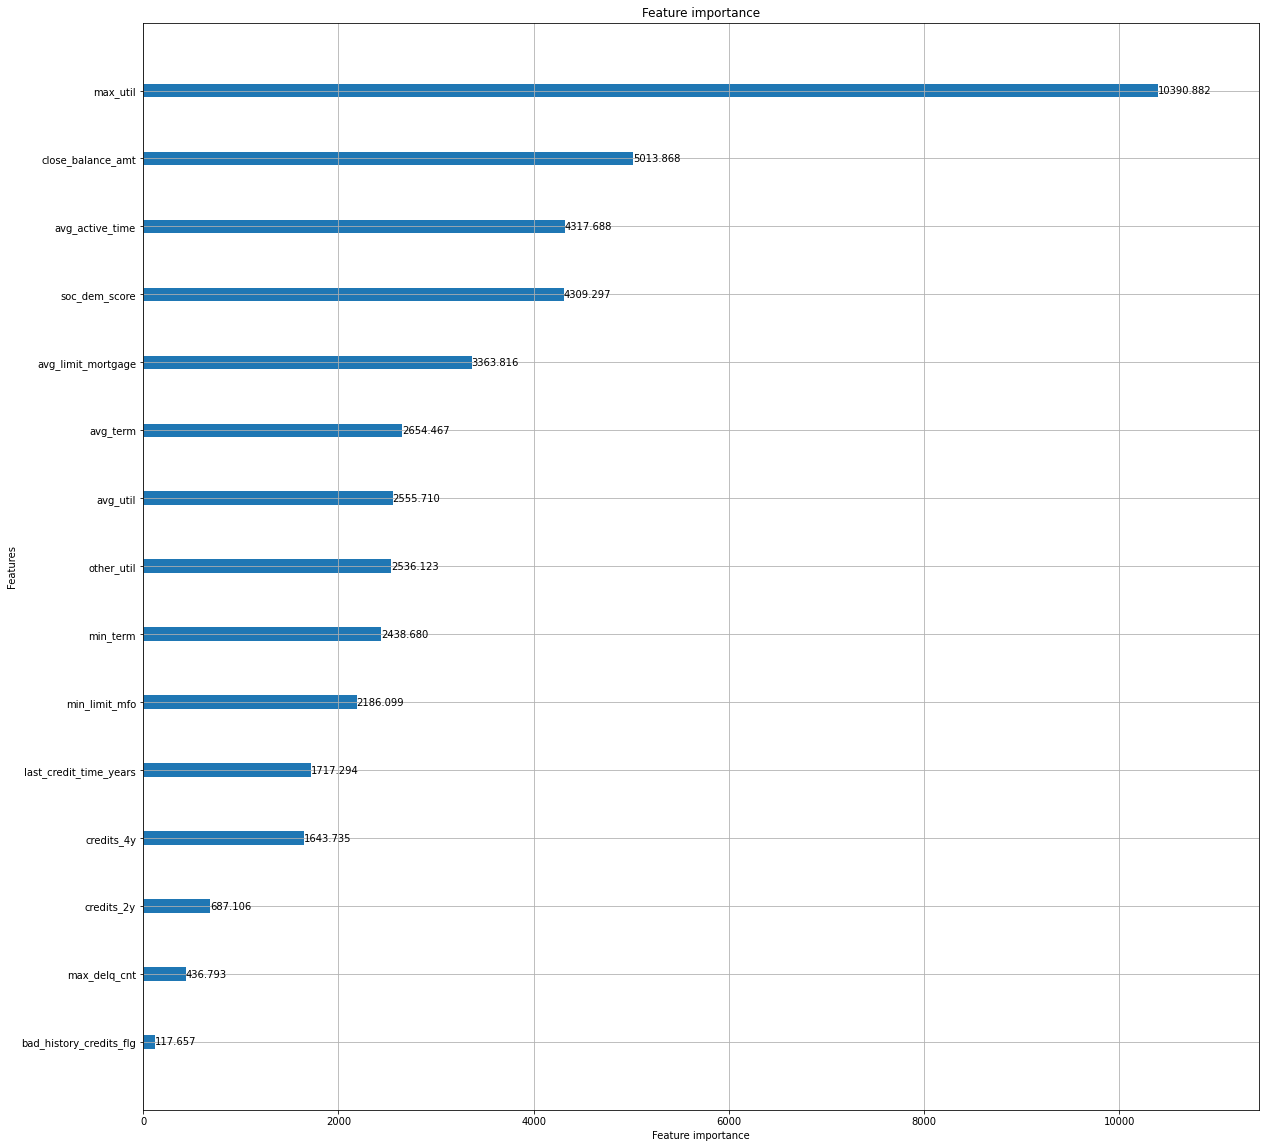

In [ ]:
plot_importance(model, importance_type='gain', max_num_features=20, figsize=(20, 20), precision=3)
plt.show()

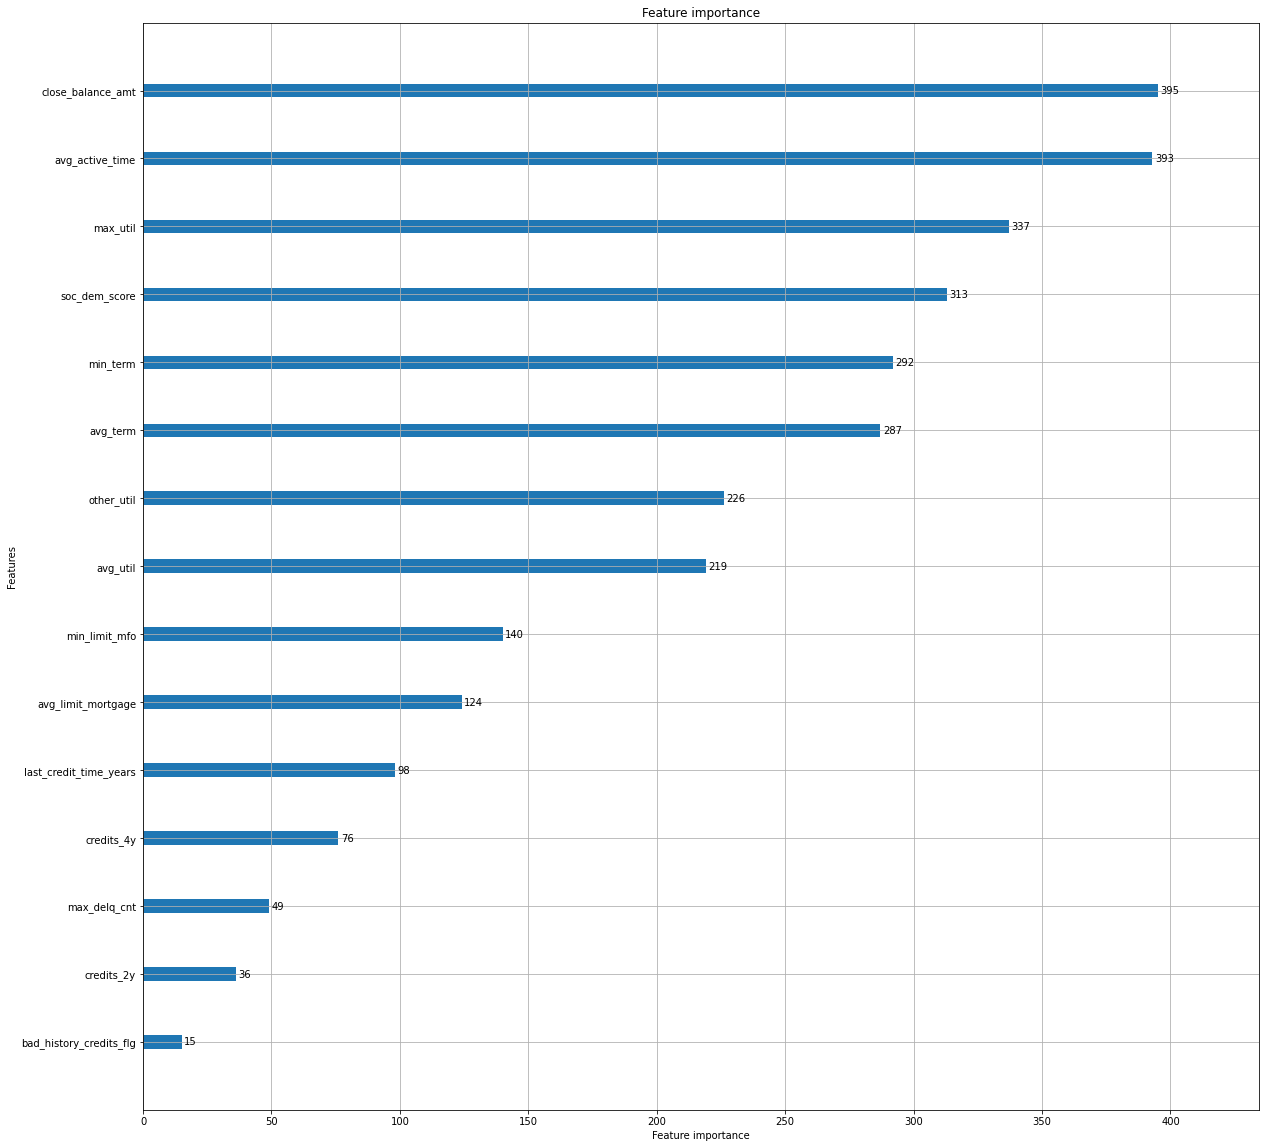

In [ ]:
plot_importance(model, importance_type='split', max_num_features=20, figsize=(20, 20), precision=3)
plt.show()

## Важность признаков линейной модели

In [ ]:
pipe = Pipeline([('scaler', StandardScaler()), ('model', LogisticRegression(penalty='none', fit_intercept=True, max_iter=1500))])
pipe.fit(df[features[:25]][df['sample_part'] == 'train'],\
         df['d4p12'][df['sample_part'] == 'train'])

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1500, penalty='none'))])

In [ ]:
df['logreg_predict'] = pipe.predict_proba(df[features])[:, 1]

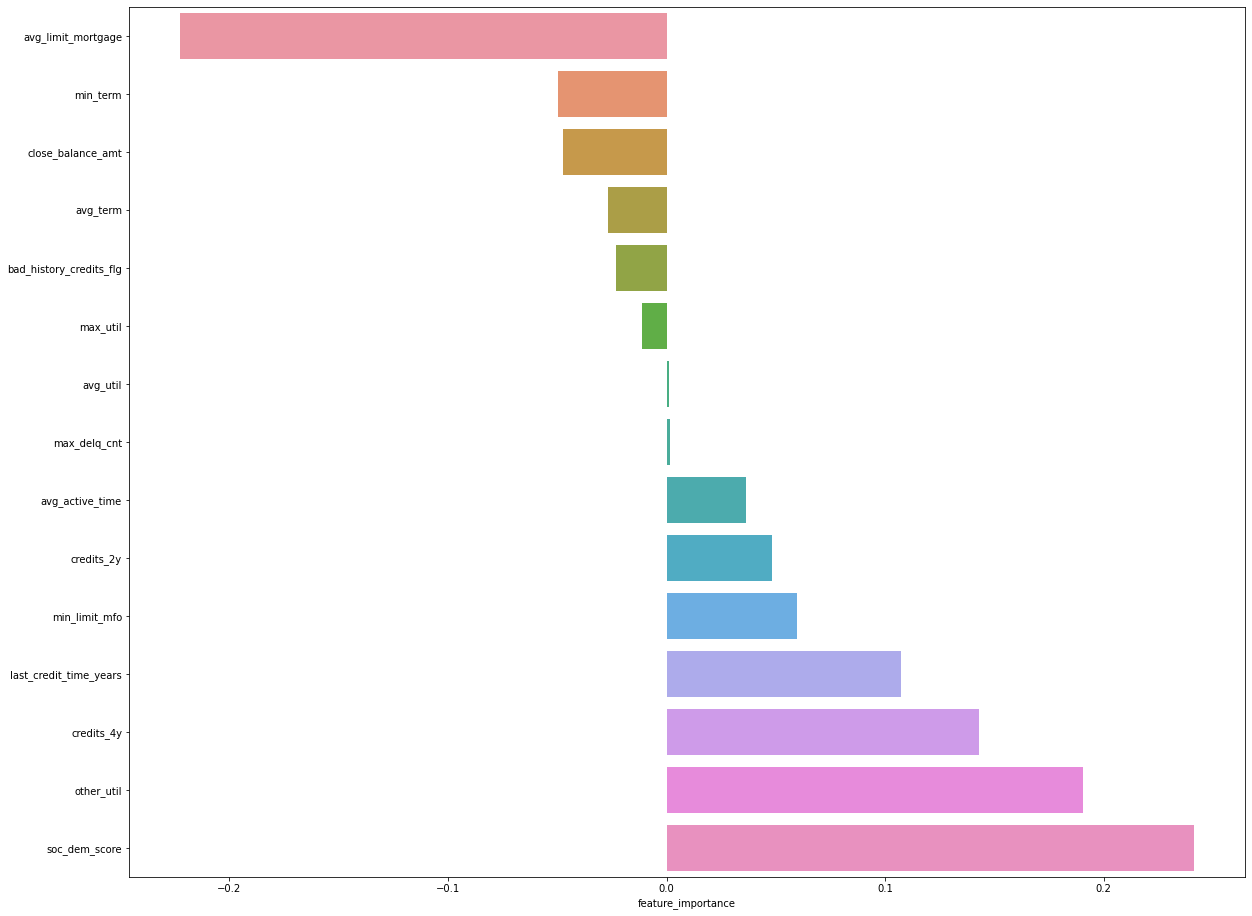

In [ ]:
coef = pd.DataFrame(pipe.get_params()['model'].coef_[0],index=features[:25], columns=['feature_importance']).sort_values(by=['feature_importance'])
plot = sns.barplot(y=coef.index, x=coef['feature_importance'])
plot.figure.set_size_inches(20, 16)

## Значение метрик на тесте

In [ ]:
df['gb_predict'] = model.predict_proba(df[features])[:, 1]

In [ ]:
print(f"Значение ROC-AUC на тесте у линейной модели:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'test'], df['logreg_predict'][df['sample_part'] == 'test']), 3)}")

Значение ROC-AUC на тесте у линейной модели:0.613


In [ ]:
print(f"Значение ROC-AUC на тесте у бустинга:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'test'], df['gb_predict'][df['sample_part'] == 'test']), 3)}")

Значение ROC-AUC на тесте у бустинга:0.643


In [ ]:
print(f"Значение ROC-AUC на трейне у линейной модели:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'train'], df['logreg_predict'][df['sample_part'] == 'train']), 3)}")

Значение ROC-AUC на трейне у линейной модели:0.648


In [ ]:
print(f"Значение ROC-AUC на трейне у линейной модели:{round(roc_auc_score(df['d4p12'][df['sample_part'] == 'train'], df['gb_predict'][df['sample_part'] == 'train']), 3)}")

Значение ROC-AUC на трейне у линейной модели:0.763
